In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [ ]:
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
cs_data = pd.read_csv(url_cs)
cs_data

,ID,aa,theo,exp,cat
0,1BM8,ILE,61.18,58.27,Non-Polar
1,1BM8,TYR,56.95,56.18,Polar
2,1BM8,SER,56.35,56.84,Polar
3,1BM8,ALA,51.96,51.01,Special
4,1BM8,ARG,56.54,54.64,Charged
...,...,...,...,...,...
1771,1KS9,LYS,55.79,57.51,Charged
1772,1KS9,ARG,58.91,59.02,Charged
1773,1KS9,LYS,59.49,58.92,Charged
1774,1KS9,GLU,59.48,58.36,Charged


In [ ]:
diff_TminusE = cs_data.theo - cs_data.exp
#adds a column called 'diff_TminusE' as the fifth column of cs_data
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)

In [ ]:
aa_encode = pd.Categorical(cs_data['aa'])
aa_encode

['ILE', 'TYR', 'SER', 'ALA', 'ARG', ..., 'LYS', 'ARG', 'LYS', 'GLU', 'SER']
Length: 1776
Categories (19, object): ['ALA', 'ARG', 'ASN', 'ASP', ..., 'THR', 'TRP', 'TYR', 'VAL']

In [ ]:
aa_idx = aa_encode.codes
aa_idx

array([ 8, 17, 14, ..., 10,  5, 14], dtype=int8)

In [ ]:
aa_coords = {"aa": aa_encode.categories}
aa_coords

{'aa': Index(['ALA', 'ARG', 'ASN', 'ASP', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU',
        'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'],
       dtype='object')}

In [ ]:
with pm.Model(coords=aa_coords) as cs_h_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.Normal('μ',
                  mu = μ_mu, # I include the hyperprior in my prior
                  sigma = μ_sd, # I include the hyperprior in my prior
                  dims = "aa")

    σ = pm.HalfNormal('σ', sigma = 10,
                      dims = "aa")

    #likelihood; same as before
    y = pm.Normal('y',
                  mu = μ[aa_idx], #I include the prior in my likelihood
                  sigma = σ[aa_idx], #I include the prior in my likelihood
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_h = pm.sample()

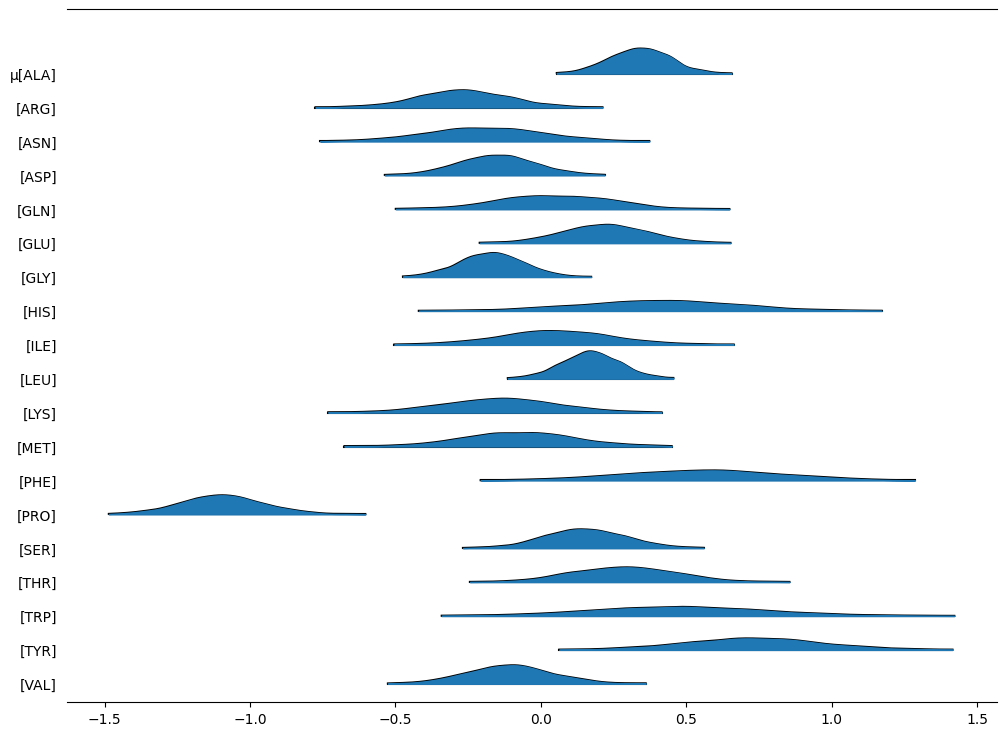

In [ ]:
axes = az.plot_forest(idata_cs_h, kind="ridgeplot",
                      var_names='μ',
                      combined=True, figsize=(12, 9), hdi_prob=0.997)


In [ ]:
with pm.Model(coords=aa_coords) as cs_hstudent_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.StudentT('μ_mu', nu = 30, mu = 0, sigma = 10)
    μ_sd = pm.HalfStudentT('μ_sd', nu = 30, sigma = 10)
    μ_nu = pm.Exponential('μ_nu', lam = 1/30)


    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.StudentT('μ',
                  mu = μ_mu, # I include the hyperprior in my prior
                  sigma = μ_sd, # I include the hyperprior in my prior
                  nu = μ_nu,
                  dims = "aa")

    σ = pm.HalfStudentT('σ', sigma = 10, nu = 30,  dims = "aa")

    ν = pm.Exponential ('ν', lam = 1/30,  dims = "aa" )

    #likelihood; same as before
    y = pm.StudentT('y',
                  mu = μ[aa_idx], #I include the prior in my likelihood
                  sigma = σ[aa_idx], #I include the prior in my likelihood
                  nu = ν[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_hstudent = pm.sample()

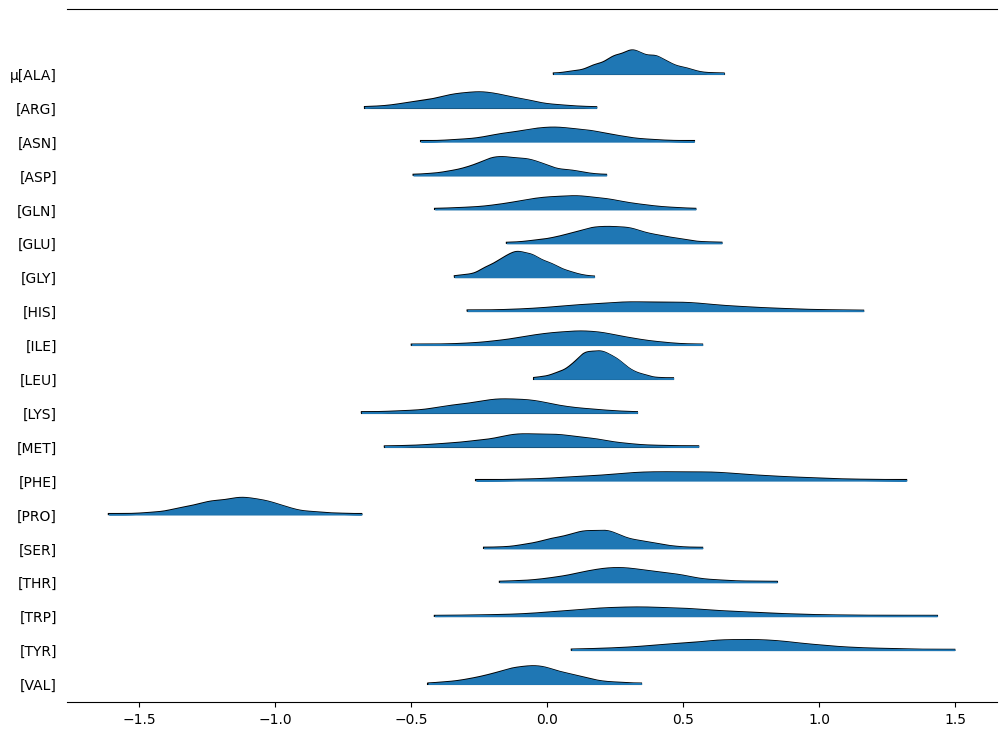

In [ ]:
axes = az.plot_forest(idata_cs_hstudent, kind="ridgeplot",
                      var_names='μ',
                      combined=True, figsize=(12, 9), hdi_prob=0.997)

Overall pretty similar.

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

Output()

Output()

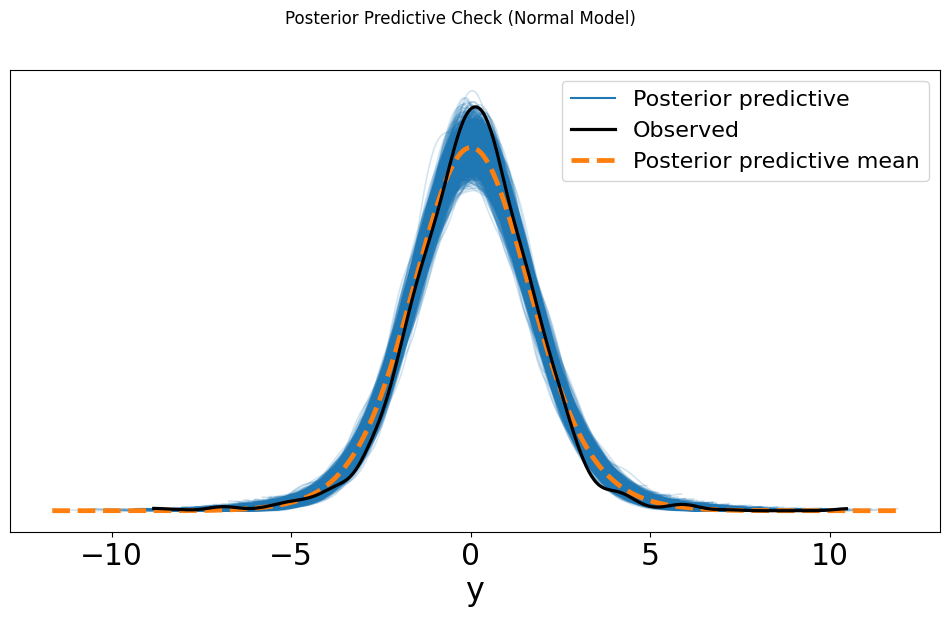

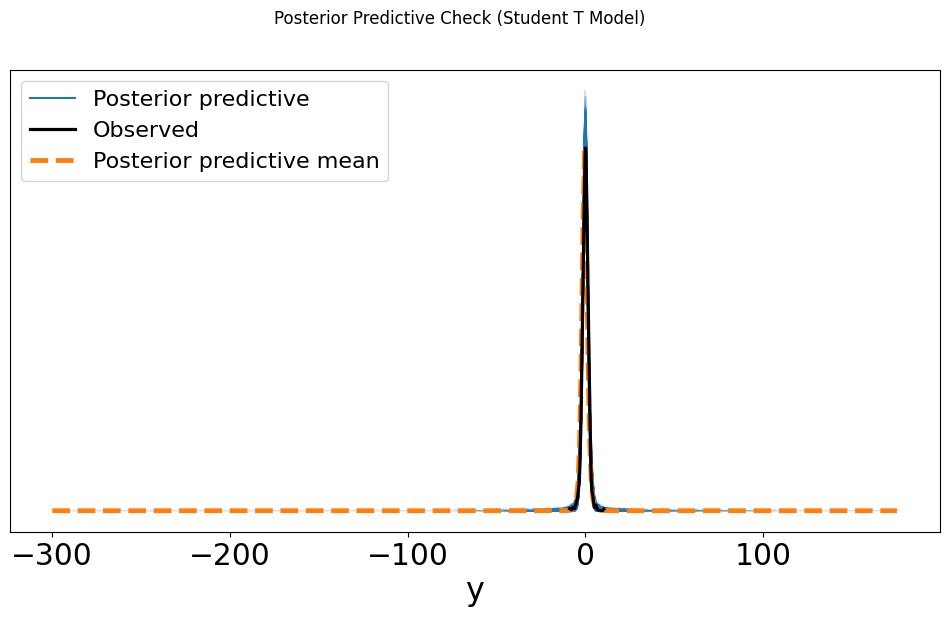

In [ ]:
# Posterior predictive check for the Normal model
with cs_h_model:
    idata_cs_h.extend(pm.sample_posterior_predictive(idata_cs_h))

# Posterior predictive check for the Student T model
with cs_hstudent_model:
    idata_cs_hstudent.extend(pm.sample_posterior_predictive(idata_cs_hstudent))

# Plot the posterior predictive checks
az.plot_ppc(idata_cs_h, kind='kde', figsize=(12, 6))
plt.suptitle("Posterior Predictive Check (Normal Model)")
plt.show()

az.plot_ppc(idata_cs_hstudent, kind='kde', figsize=(12, 6))
plt.suptitle("Posterior Predictive Check (Student T Model)")
plt.show()

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [ ]:
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'

#Turns the position column into a categorical variable
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})

In [ ]:
sccr_data


,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2677,Óscar Mingueza,DF,2,12
2678,Óscar Plano,MF,12,124
2679,Óscar Rodríguez,MF,13,133
2680,Óscar Trejo,MF,1,20


In [ ]:
#this is an array of the soccer positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = sccr_data.position.cat.codes.values

#an array of the four strings that represent position
pos_codes = sccr_data.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords = {"pos": pos_codes}

In [ ]:
with pm.Model(coords = sccr_coords) as sccr_model:

    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = 1/11, nu = 55, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr = pm.sample(target_accept = 0.95)

**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

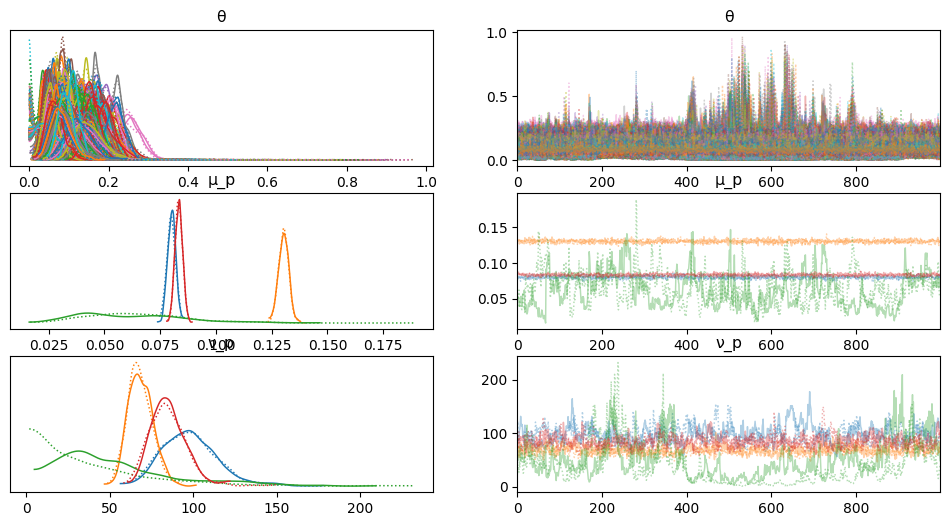

In [ ]:
az.plot_trace(idata_sccr)

In [ ]:
az.rhat(idata_sccr)


<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.007 0.9994 1.001 ... 0.9997 0.9995 0.9996
    μ_p      (pos) float64 32B 1.007 1.001 1.018 0.9997
    ν_p      (pos) float64 32B 1.028 1.003 1.128 1.001

Overall the rhat values are kind of similar, with mu tending to be lower for non hierarchical and nu being higher. Highlight to see the values.

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

Text(0.5, 1.0, 'Goalkeeper position mean')

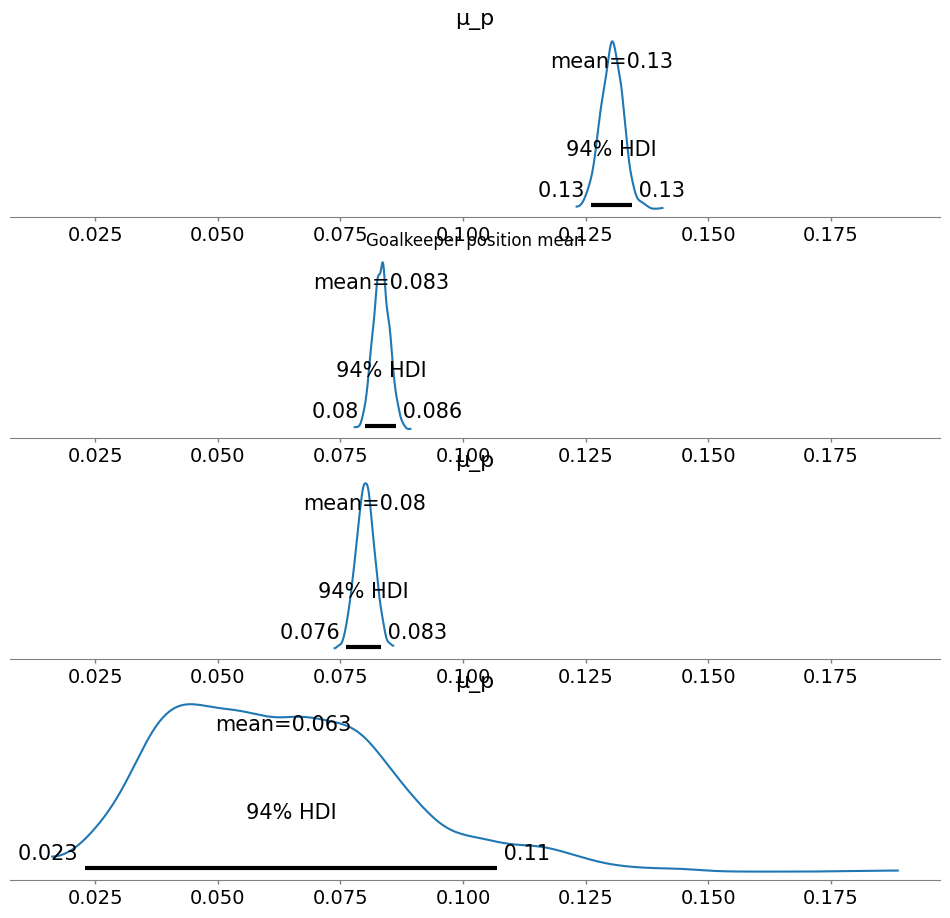

In [ ]:
_, ax = plt.subplots(4, 1, figsize=(12, 11), sharex=True)


az.plot_posterior(idata_sccr.posterior.sel(pos="FW"), var_names='μ_p', ax=ax[0])
ax[1].set_title(r"Forward position mean")

az.plot_posterior(idata_sccr.posterior.sel(pos="MF"), var_names='μ_p', ax=ax[1])
ax[1].set_title(r"Midfield position mean")

az.plot_posterior(idata_sccr.posterior.sel(pos="DF"), var_names='μ_p', ax=ax[2])
ax[1].set_title(r"Defender position mean")

az.plot_posterior(idata_sccr.posterior.sel(pos="GK"), var_names='μ_p', ax=ax[3])
ax[1].set_title(r"Goalkeeper position mean")

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [ ]:
no_goalkeepers = sccr_data.query('position != "GK"')
no_goalkeepers

,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2677,Óscar Mingueza,DF,2,12
2678,Óscar Plano,MF,12,124
2679,Óscar Rodríguez,MF,13,133
2680,Óscar Trejo,MF,1,20


In [ ]:
# Prepare data for the new hierarchical model
no_goalkeepers['position_no_gk'] = no_goalkeepers['position'].cat.remove_unused_categories()
no_gk_pos_idx = no_goalkeepers.position_no_gk.cat.codes.values
no_gk_pos_codes = no_goalkeepers.position_no_gk.cat.categories
no_gk_sccr_coords = {"pos": no_gk_pos_codes}

# Build the hierarchical model without goalkeepers
with pm.Model(coords=no_gk_sccr_coords) as sccr_h_no_gk_model:
    # Hyperpriors
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)

    # Priors
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Player parameters
    θ = pm.Beta('θ', mu = μ_p[no_gk_pos_idx], nu = ν_p[no_gk_pos_idx])

    # Likelihood
    _ = pm.Binomial('gs', n = no_goalkeepers.shots.values, p = θ, observed = no_goalkeepers.goals.values)

    # Sample
    idata_sccr_h_no_gk = pm.sample(target_accept=0.95)

**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

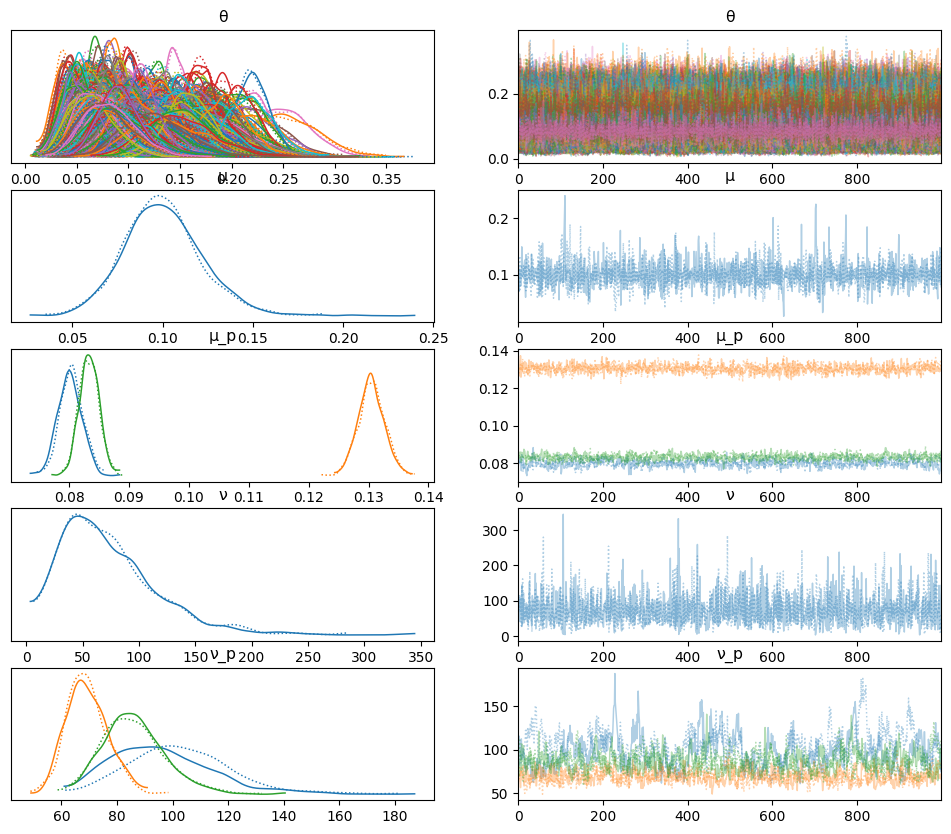

In [ ]:
az.plot_trace(idata_sccr_h_no_gk)

In [ ]:
az.rhat(idata_sccr_h_no_gk)


<xarray.Dataset> Size: 40kB
Dimensions:  (θ_dim_0: 2517, pos: 3)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 20kB 0 1 2 3 4 5 ... 2511 2512 2513 2514 2515 2516
  * pos      (pos) <U2 24B 'DF' 'FW' 'MF'
Data variables:
    θ        (θ_dim_0) float64 20kB 0.9999 1.0 1.001 1.003 ... 1.0 1.001 1.003
    μ        float64 8B 1.002
    μ_p      (pos) float64 24B 1.006 1.004 1.0
    ν        float64 8B 1.0
    ν_p      (pos) float64 24B 1.025 1.0 1.004

The model without goal keepers was easier for pymc to process, probably because it wasn't skewing the data and creating more outliers. By getting rid of goal keepers, we lose the input they have on the overall average, but make the average between the other positions more accurate.